# Optimization of MI parameters for a Pfam MSA  

This tutorial shows you how the methods on the **MIToS’ Pfam module** can be used to **optimize the parameters** of a **corrected MI** (Mutual Information) estimation. The optimization is performed to maximize the *Area Under the* Receiver Operating Characteristic (ROC) *Curve (AUC)* for protein contact prediction.   

In [1]:
using MIToS.Pfam

In this example, we are going to optimize the parameters for **buslje09** from MIToS’ **Information module.**  

In [2]:
using MIToS.Information

We can use the `downloadpfam` function to download a MSA from Pfam and save it in the working directory. 

In [3]:
pfam_acc  = "PF00890" # Pfam accession
pfam_file = downloadpfam(pfam_acc)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3059k  100 3059k    0     0   133k      0  0:00:22  0:00:22 --:--:--  270k


"PF00890.stockholm.gz"

In order to working with that MSA, we are going to use the method `read`. This method is going to use `parse` to generate the `AnnotatedMultipleSequenceAlignment` from the Stockholm file. Since were are going to need a reference to associate protein contacts and buslje09 scores, we are going to generate the column and sequence mapping using the keyword arguments `generatemapping` and `useidcoordinates` setted to `true` (see the `parse` documentation). This is safe because we are working with a Pfam MSA without modifications but you should be careful if you read a file generated by MIToS. 

In [4]:
const msa = read(pfam_file, Stockholm, generatemapping=true, useidcoordinates=true)

6433x417 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 D  V  L  I  V  G  G  G  V  S  A  T  F  …  -  -  -  -  -  -  -  -  -  -  -  -
 D  A  V  I  V  G  A  G  G  A  G  L  R     V  H  G  A  N  R  L  G  T  N  S  L
 D  F  L  V  I  G  S  G  L  A  G  M  S     L  H  G  G  N  R  L  A  S  N  S  L
 D  V  I  V  V  G  A  G  A  A  G  L  Y     V  H  G  A  N  R  L  A  S  N  S  L
 D  V  L  I  I  G  A  G  L  A  G  L  S     L  H  G  A  N  R  L  A  S  N  S  L
 D  V  I  V  V  G  A  G  G  A  G  L  R  …  V  H  G  A  N  R  L  G  S  N  S  L
 D  V  V  I  L  G  Y  G  G  A  G  A  S     W  G  H  I  Y  Q  G  A  T  N  -  -
 D  F  L  V  I  G  S  G  I  A  G  M  S     L  H  G  G  N  R  L  A  S  N  S  L
 -  I  V  I  I  G  A  G  L  G  A  L  Y     L  H  G  A  N  R  L  A  S  N  G  L
 -  -  -  -  -  -  -  -  -  -  -  -  -     -  -  -  -  -  -  -  -  -  -  -  -
 D  V  V  I  L  G  G  G  S  A  G  T  I  …  P  H  -  -  -  -  -  -  -  -  -  -
 -  -  -  -  -  -  -  -  -  -  -  -  -     -  -  -  -  -  -  -  -  -  -  -  -
 D  V  I 

MSA is defined as a `const` for performance reason because it’s a global variable that will be use inside the optimization loop.  
If we are going to use only a subset of columns, the best option is making the selection before the optimization (in order to avoid it inside the optimization loop).  
For example, here we are going to delete columns with more than 50% of gaps using `gapfraction` and `filtercolumns!` from MIToS' MSA module.

In [5]:
using MIToS.MSA

In [6]:
filtercolumns!(msa, gapfraction(msa, 1) .< 0.50 )

6433x374 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 D  V  L  I  V  G  G  G  V  S  A  T  F  …  -  -  -  -  -  -  -  -  -  -  -  -
 D  A  V  I  V  G  A  G  G  A  G  L  R     V  H  G  A  N  R  L  G  T  N  S  L
 D  F  L  V  I  G  S  G  L  A  G  M  S     L  H  G  G  N  R  L  A  S  N  S  L
 D  V  I  V  V  G  A  G  A  A  G  L  Y     V  H  G  A  N  R  L  A  S  N  S  L
 D  V  L  I  I  G  A  G  L  A  G  L  S     L  H  G  A  N  R  L  A  S  N  S  L
 D  V  I  V  V  G  A  G  G  A  G  L  R  …  V  H  G  A  N  R  L  G  S  N  S  L
 D  V  V  I  L  G  Y  G  G  A  G  A  S     W  G  H  I  Y  Q  G  A  T  N  -  -
 D  F  L  V  I  G  S  G  I  A  G  M  S     L  H  G  G  N  R  L  A  S  N  S  L
 -  I  V  I  I  G  A  G  L  G  A  L  Y     L  H  G  A  N  R  L  A  S  N  G  L
 -  -  -  -  -  -  -  -  -  -  -  -  -     -  -  -  -  -  -  -  -  -  -  -  -
 D  V  V  I  L  G  G  G  S  A  G  T  I  …  P  H  -  -  -  -  -  -  -  -  -  -
 -  -  -  -  -  -  -  -  -  -  -  -  -     -  -  -  -  -  -  -  -  -  -  -  -
 D  V  I 

To measure performance of contact prediction, we need to have at least one PDB structure for the MSA. We can use `getseq2pdb` in order to get a `Dict` with the PDB codes annotated in the MSA for each sequence.

In [7]:
seq2pdb = getseq2pdb(msa)

Dict{ASCIIString,Array{Tuple{ASCIIString,ASCIIString},1}} with 12 entries:
  "SDHA_ECOLI/9-405"     => [("2WU2","A"),("2WS3","E"),("1NEK","A"),("2WU5","A"…
  "FRDA_SHEON/152-575"   => [("1D4C","C"),("1D4E","A"),("1D4C","D"),("1D4D","A"…
  "FRD2_SHEFN/145-567"   => [("1QO8","D"),("1QO8","A")]
  "SDHA_PIG/63-457"      => [("3AE9","A"),("3AEF","A"),("3AE5","A"),("3AEA","A"…
  "F9UUF7_LACPL/107-547" => [("2LFC","A")]
  "O28603_ARCFU/24-267"  => [("1JNR","C"),("1JNZ","A"),("2FJE","C"),("1JNZ","C"…
  "FRDA_WOLSU/7-410"     => [("2BS3","A"),("2BS4","A"),("2BS4","D"),("2BS2","A"…
  "FRDA_ECOLI/7-397"     => [("1KF6","A"),("2B76","A"),("3P4R","M"),("3CIR","A"…
  "SDHA_CHICK/64-458"    => [("1YQ3","A"),("2FBW","A"),("2WQY","N"),("2H88","A"…
  "NADB_ECOLI/10-392"    => [("1KNR","A"),("1KNP","A"),("1CHU","A")]
  "Q0S4Q9_RHOJR/23-472"  => [("4AT2","A"),("4AT0","A")]
  "NADB_SULTO/2-354"     => [("2E5V","A"),("2E5V","B")]

You can choose any of those PDB files, i.e. the PDB which cover more columns of the MSA.  

For this example we are going to choose **1D4C (chain A)** as in the Figure I of *Buslje, C. Marino, et al. "Networks of high mutual information define the structural proximity of catalytic sites: implications for catalytic residue identification." PLoS Comput Biol 6.11 (2010): e1000978-e1000978.*  

We are going to use `MIToS.PDB` in order to download and parse/`read` the PDBML structure of *1D4C* into a list of `PDBResidue`s. We are going to use a `residuedict` for getting a `OrderedDict` from PDB resnum to `PDBResidue` only with the residues in the ATOM group from the model 1 and the chain A.

In [8]:
using MIToS.PDB

In [9]:
pdb_code   = "1D4C"
chain      = "A"

pdbml_file = downloadpdb(pdb_code)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  690k    0  690k    0     0   211k      0 --:--:--  0:00:03 --:--:--  211

"1D4C.xml.gz"

In [10]:
residues = residuesdict(read(pdbml_file, PDBML), "1", chain, "ATOM", "*") # model 1 chain A group ATOM residues all

DataStructures.OrderedDict{ASCIIString,MIToS.PDB.PDBResidue} with 570 entries:
  "1"  => PDBResidue:…
  "2"  => PDBResidue:…
  "3"  => PDBResidue:…
  "4"  => PDBResidue:…
  "5"  => PDBResidue:…
  "6"  => PDBResidue:…
  "7"  => PDBResidue:…
  "8"  => PDBResidue:…
  "9"  => PDBResidue:…
  "10" => PDBResidue:…
  "11" => PDBResidue:…
  "12" => PDBResidue:…
  "13" => PDBResidue:…
  "14" => PDBResidue:…
  "15" => PDBResidue:…
  "16" => PDBResidue:…
  "17" => PDBResidue:…
  "18" => PDBResidue:…
  "19" => PDBResidue:…
  "20" => PDBResidue:…
  "21" => PDBResidue:…
  "22" => PDBResidue:…
  "23" => PDBResidue:…
  "24" => PDBResidue:…
  "25" => PDBResidue:…
  ⋮    => ⋮

k


We need to obtain the ID of the UniProt sequence associated to that PDB.  

In [11]:
"Returns the list of sequence ids on `dict` associated to that `pdb` code and `chain`"
function getseqid(pdb, chain, dict)
    ids = ASCIIString[]
    for (seqid, pdblist) in dict
        if (pdb, chain) in pdblist
            push!(ids, seqid)
        end
    end
    ids
end

seqids = getseqid("1D4C", "A", seq2pdb)

1-element Array{ASCIIString,1}:
 "FRDA_SHEON/152-575"

In [12]:
seq_id  = seqids[1]

"FRDA_SHEON/152-575"

This ids we can be used to obtain the mapping between the MSA columns in the file and the PDB residues. `msacolumn2pdbresidue` uses *SIFTS* and the *ColMap* and *SeqMap* annotations generated by `read` for doing the mapping between the columns in the MSA file and the PDB residues (using **UniProt** coordinates for the mapping).

In [13]:
col2res = msacolumn2pdbresidue(seq_id, pdb_code, chain, msa)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   98k  100   98k    0     0  129

Dict{Int64,ASCIIString} with 374 entries:
  2381 => "538"
  712  => "229"
  1131 => "279"
  2401 => "549"
  2047 => "475"
  1265 => "302"
  2094 => "488"
  2287 => "517"
  835  => "235"
  610  => "210"
  1442 => "348"
  1819 => "414"
  2283 => "515"
  1816 => "411"
  1386 => "335"
  1400 => "337"
  227  => "150"
  589  => "207"
  685  => "224"
  157  => "140"
  2327 => "521"
  264  => "158"
  797  => ""
  353  => "172"
  1446 => "351"
  ⋮    => ⋮

66      0  0:00:07  0:00:07 --:--:-- 28192


The mapping between the MSA and the residues together with the ordered dictionary of `PDBResidue`s can be used for getting the contact map using only the residues included in the MSA.

In [14]:
contactmap = msacontacts(msa, residues, col2res)

374x374 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 NaN      1.0    1.0    0.0    0.0    0.0  …    0.0    0.0    0.0    0.0  NaN
   1.0  NaN      1.0    1.0    0.0    0.0       0.0    0.0    0.0    0.0  NaN
   1.0    1.0  NaN      1.0    1.0    0.0       0.0    0.0    0.0    0.0  NaN
   0.0    1.0    1.0  NaN      1.0    1.0       0.0    0.0    0.0    0.0  NaN
   0.0    0.0    1.0    1.0  NaN      1.0       0.0    0.0    0.0    0.0  NaN
   0.0    0.0    0.0    1.0    1.0  NaN    …    0.0    0.0    0.0    0.0  NaN
   0.0    0.0    0.0    0.0    1.0    1.0       0.0    0.0    0.0    0.0  NaN
   0.0    0.0    0.0    0.0    0.0    1.0       0.0    0.0    0.0    0.0  NaN
   0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0  NaN
   0.0    0.0    0.0    1.0    0.0    1.0       0.0    0.0    0.0    0.0  NaN
   0.0    0.0    0.0    1.0    1.0    1.0  …    0.0    0.0    0.0    0.0  NaN
   0.0    0.0    0.0    1.0    0.0    1.0       0.0    0.0    0.0    0.0  NaN


We can obtain two `BitVector` masks, to be used for the AUC calculation before the optimization iteration, in order to reduce the number of operations inside the objective function. This masks should be `const` to not lose performance.

In [15]:
const truecontacts, notcontacts = getcontactmasks(contactmap)

(Bool[true,true,false,false,false,false,false,false,false,false  …  true,true,true,false,true,true,false,true,false,false],Bool[false,false,true,true,true,true,true,true,true,true  …  false,false,false,false,false,false,false,false,false,false])

**NOTE:** Here we don’t need to use the `PairwiseListMatrices`’ `join` (using the MSA file column number as key) in order to match the scores and the contacts before getting the masks because we are using the same columns for both: by default buslje09 uses columns with less than 50% of gaps and we already did that filtration.

Now we are going to perform and AUC calculation, in order to test that everything its fine at the moment. We are going to use `samples=0` on buslje09 to not estimate the Z score (this is going to make faster every optimization iteration).   

In [16]:
zmip, mip = buslje09(msa, samples=0)

(
374x374 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.

In order to check that the mapping between scores and contacts is correct without calling `join` we are going to use the `AUC` call using the scores and the contact map, because this makes the `join` before getting the mask with `getcontactmasks`.

In [17]:
using Base.Test
@test AUC(mip, contactmap) == AUC(mip, truecontacts, notcontacts)

The AUC of the ROC curve before parameter optimization is: 

In [18]:
AUC(mip, truecontacts, notcontacts)

0.8205582674329265

Now we are ready to do the optimization of the `beta`, `lambda` and `threshold` parameters `using NLopt`. For that we need to define the **objective function**, which **should take** the vector of parameters and a gradient vector (we are not going to use it here) and **should return** the AUC value for contact prediction using that parameters. This is optional, but you can print or save every step of the optimization. We are going to save the values of each step on a vector `steps`, in order to analyze it later.

In [19]:
using NLopt

In [20]:
const steps = Vector{Float64}[] # Optional

0-element Array{Array{Float64,1},1}

In [21]:
function objective(parameters::Vector{Float64}, gradient::Vector{Float64})
    
    lambda    = parameters[1]
    threshold = parameters[2]
    
    zmip, mip = buslje09(msa, lambda=lambda, threshold=threshold, samples=0, maxgap=0.5)
    
    auc       = AUC(mip, truecontacts, notcontacts)
    
    push!(steps, Float64[lambda, threshold, auc]) # Optional
    
    auc
end

objective (generic function with 1 method)

In [22]:
@test AUC(mip, contactmap) ==  objective([0.05, 0.62], Float64[]) # Test objective function

In [23]:
steps # Test objective function

1-element Array{Array{Float64,1},1}:
 [0.05,0.62,0.8205582674329265]

We are going to perform a **global optimization** using the **Controlled Random Search** (CRS) algorithm (the CRS2 variant) with the **Local Mutation** (LM) modification from NLopt.  

In [24]:
opt = Opt(:GN_CRS2_LM, 2) # 2 parameters

#                      λ  threshold
lower_bounds!(opt, [ 0.0,       0.0])
upper_bounds!(opt, [50.0,       1.0])

stopval!(opt,  1.0 - 1e-4)
ftol_abs!(opt, 1e-4)
max_objective!(opt, objective)
maxeval!(opt, 600)

#                                                       λ  threshold
optimum_auc, optimum_parameters, ret = optimize(opt, [0.0,       1.0]) # It starts with the simplest option

(0.8593725448510768,[10.448314396946909,0.39571277823934686],:FTOL_REACHED)

As a result we get the optimum AUC value, the optimum parameters and the returned value `ret`.

In [28]:
steps_matrix = transpose(hcat(steps...)) # Convert steps to a Matrix

255x3 Array{Float64,2}:
  0.05     0.62      0.820558
  0.0      1.0       0.723348
 24.7115   0.923778  0.754414
 41.2443   0.675122  0.815658
 48.5068   0.58398   0.828076
 39.118    0.301708  0.826005
 24.6894   0.416297  0.851472
 16.1272   0.758273  0.796789
 11.1214   0.313041  0.845093
 40.9601   0.372039  0.840534
 46.4736   0.879407  0.776   
 25.7675   0.18921   0.824451
  5.55973  0.988014  0.722814
  ⋮                          
 11.1184   0.39159   0.858558
  7.75559  0.387792  0.856377
 12.1262   0.404231  0.858148
  7.55595  0.403245  0.856383
 10.4416   0.395782  0.859358
  8.3477   0.396955  0.858093
  7.36606  0.393597  0.857455
 13.0152   0.396725  0.858563
 11.4488   0.374867  0.857287
  9.64924  0.404161  0.857811
  9.29698  0.418637  0.856205
 10.4483   0.395713  0.859373

We can use the steps matrix in order to see/**plot** the optimization steps

In [26]:
using Plots

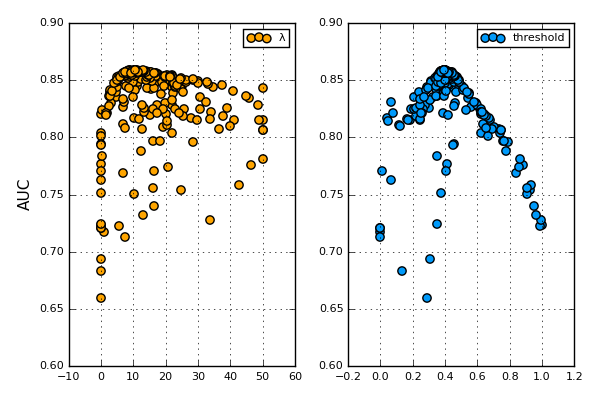

In [50]:
subplot(scatter(steps_matrix[:,1], steps_matrix[:,3], lab="λ", color=:orange, ylab="AUC"), 
scatter(steps_matrix[:,2], steps_matrix[:,3], lab = "threshold"))

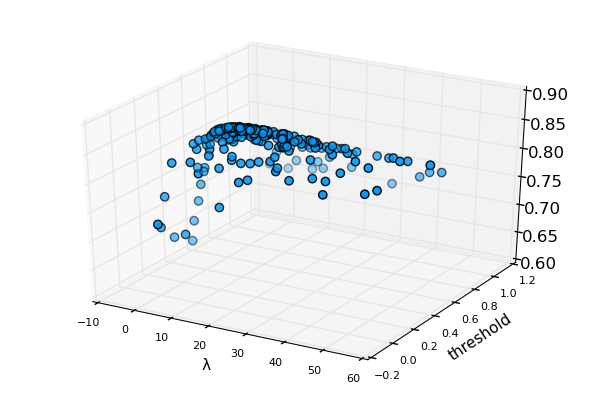

In [51]:
scatter3d(steps_matrix[:,1], steps_matrix[:,2], steps_matrix[:,3], 
xlab="λ", ylab="threshold", )